<h2>Photo-z validation metrics on Resampled Cosmos Data</h2>

This notebook shows how to load a .yaml /.p pickle file from all 200 of the resampled Alhambra/Cosmos validation files.

We then determine the error, from the spread of metric values from the 200 RS validation data, and also from the Cosmic Variance analysis.

*You will need to change the path and path_to_pickle_output_file  lines in the below cell*


In [147]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import pickle
import json
from IPython.display import display, HTML, display_pretty
import pandas
import datetime


path = '/home/carnero/photoz_repo/photoz-wg/aure_valid/'

#json_files = ['others_coadd_lss.json','portal_coadd_lss.json']
json_files = ['meta_wl.json']

science_sample = 'WL' #['LSS','WL','Y1']



In [148]:
almost_black = '#262626'
plt.rcParams['figure.figsize'] = (20, 12)
plt.rcParams.update({'font.size': 20, 
                     'axes.linewidth': 5,
                    'text.color': almost_black,
                    'xtick.major.size': 4,
                    'ytick.major.size': 4,
                    'legend.fancybox': True,
                    'figure.dpi': 300,
                    'legend.fontsize': 16,
                    'legend.framealpha': 0.8,
                    'legend.shadow': True,
                    'xtick.labelsize': 12,
                    'ytick.labelsize': 12})

<h3>Set up the requirements and plotting </h3>

Define what plotting symbols to use, and also Y5 requirements


In [149]:
class scaled_error():
    def __init__(self, const, scaling_type):
        self.const = const
        self.scaling = None
        if scaling_type == 'one_plus_z':
            self.scaling = self.one_plus_z 
        else:
            self.scaling = self.const_with_z
        
    def one_plus_z(self, z):
        return np.array((1 + z) * self.const)
    
    def const_with_z(self, z):
        return np.array(len(z) * [self.const])
    

In [150]:


#requirements from science handbook
# http://des-docdb.fnal.gov:8080/cgi-bin/RetrieveFile?docid=20&filename=sciReq-9.86.pdf&version=32
# http://des-docdb.fnal.gov:8080/cgi-bin/ShowDocument?docid=1719
requirements = {'sigma_68':{'value': scaled_error(0.12, 'const'), 'error': scaled_error(0.003, 'const')},
                'wl_metric': {'value': scaled_error( 0.02, 'const'), 'error': scaled_error(0.02, 'const')},
                'outFrac_2sigma68': { 'value': scaled_error(0.1, 'one_plus_z') , 'error': scaled_error(0.001, 'const') },
#                'outFrac_3sigma68': {'value': scaled_error(0.015, 'one_plus_z'), 'error': scaled_error(0.0015, 'const') },
                'median': {'value': scaled_error(0, 'one_plus_z'), 'error': scaled_error(0.001, 'one_plus_z') },
#                'median_1pz': {'value': scaled_error(0, 'one_plus_z'), 'error': scaled_error(0.001, 'one_plus_z') },
                }

    
#plotting ranges
plt_range = {'sigma_68': [0, 0.5],
            'wl_metric': [0, 0.1],
            'outFrac_2sigma68': [0, 0.3],
            'outFrac_3sigma68': [0, 0.3],
             'median' : [-0.1, 0.1],
             'sigma_68_1pz': [0, 0.2],
            'median_1pz': [-0.1, 0.1]
             
            }

metric_latex = {
    'sigma_68' :'$\sigma_{68}(z_{true} - z_{pred})$',
    'sigma_68_1pz' :'$\sigma_{68}((z_{true} - z_{pred})/(1 + z_{true}))$',
    'wl_metric': '$|<z_{true}> - <z^{MC}_{pred}>|$',
    'outFrac_2sigma68': '$f(>2*\sigma_{68})$',
    'outFrac_3sigma68': '$f(>3*\sigma_{68})$',
    'outFrac_2sigma68_1pz': '$f(>2*\sigma_{68}/(1+z))$',
    'outFrac_3sigma68_1pz': '$f(>3*\sigma_{68}/(1+z))$',
    'median' : '$\mu(z_{true} - z_{pred})$',
    'median_1pz' : '$\mu(z_{true} - z_{pred})/(1 + z_{true})$',
    'delta_sigma_crit': '$\Delta \Sigma_{C}'
}

metric_description = {
    'sigma_68' :'68% spread (std.) of delta=(z_true - z_phot)',
    'sigma_68_1pz' :'68% spread of delta=(z_true - z_phot)/(1 + z_true))',
    'wl_metric': '|<z_true> - <z^MC_phot>|$',
    'outFrac_2sigma68': 'Frac. data with abs(delta) >2*sigma_68',
    'outFrac_3sigma68': 'Frac data with abs(detla) >3*sigma_68',
    'outFrac_2sigma68_1pz': 'Frac data with abs(deta/(1+z)) >2*sigma_68',
    'outFrac_3sigma68_1pz': 'Frac data with abs(deta/(1+z)) >3*sigma_68',
    'median' : '$median(z_true - z_phot)$',
    'median_1pz' : '$median (delta/(1+z)$',
    'delta_sigma_crit': '$Delta Sigma Critical'
}




<h3>Metrics of interest</h3>

Let us decide which metrics we want to measure. Edit this list with metrics that we measured from the validation script. Look at the structure of the validation .yaml file to understand this indexing.

In [151]:
if science_sample == 'WL':
    #what is the WL binning structure.
    bins = [0.1, 0.2, 0.43, 0.63, 0.9, 1.3]

    
if science_sample == 'LSS':
    
    #lss has other different requirements
    requirements = {
                'sigma_68':{ 'value': scaled_error(0.03, 'one_plus_z') , 'error': scaled_error(0.03, 'const')},
                'outFrac_2sigma68': { 'value': scaled_error(0.1, 'const') , 'error': scaled_error(0.001, 'const') },
                'outFrac_3sigma68': {'value': scaled_error(0.015, 'const'), 'error': scaled_error(0.0015, 'const') },
                'median': {'value': scaled_error(0, 'one_plus_z'), 'error': scaled_error(0.001, 'one_plus_z') },
                'median_1pz': {'value': scaled_error(0, 'const_with_z'), 'error': scaled_error(0.001, 'one_plus_z') },
                'sigma_68_1pz':{ 'value': scaled_error(0.03, 'const_with_z') , 'error': scaled_error(0.03, 'const')},
             }
          
    
    
    #plotting ranges
    plt_range = {
        'sigma_68': [0, 0.2],
        'sigma_68_1pz': [0, 0.1],
        'outFrac_2sigma68': [0, 0.15],
        'outFrac_3sigma68': [0, 0.1],
        'median' : [-0.05, 0.05],
        'median_1pz': [-0.02, 0.02]
        
            }
    #what is the WL binning structure.
    bins = [0.6, 0.7, 0.8, 0.9, 1.0]

if science_sample == 'Y1':
    
    bins = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.2,1.4]
    
    
    


<h3>Load results files</h3>

Now let's load the json files from the validation pipeline.


In [152]:
#path = '/home/carnero/photoz_repo/photoz-wg/aure_valid/'

#json_files = ['coadd_lss.json','external_lss.json']

results = []
for js in json_files:
    with open(path+js) as json_data:
        results +=json.load(json_data)
        json_data.close()
#print results
codes = {}

columns = []

for result in results:
    codes[result['algorithm']] = result
    columns.append(result['algorithm'])
    
general_statistics = {}

for cc in columns:
    index = []
    general_statistics[cc]=[]
    for hid in requirements:
        index.append(hid)
        try:
            general_statistics[cc].append(str(codes[cc][hid][0])+' +- '+str(codes[cc][hid][1]))
        except:
            general_statistics[cc].append('-- +- --')

df = pandas.DataFrame(data=general_statistics, index=index)

display_pretty(df)

                             annz2            bpzHIZ               dnf  \
wl_metric         0.0553 +- 0.0122  0.0428 +- 0.0123  0.0509 +- 0.0121   
outFrac_2sigma68  0.0689 +- 0.0029          -- +- --   0.0769 +- 0.003   
median            -0.0109 +- 0.008  -0.0412 +- 0.008  -0.0092 +- 0.008   
sigma_68          0.2553 +- 0.0108  0.2501 +- 0.0103  0.2408 +- 0.0106   

                            lephare               tpz  
wl_metric          0.9502 +- 0.0481  0.0898 +- 0.0122  
outFrac_2sigma68    0.0781 +- 0.003  0.0738 +- 0.0029  
median            -0.0273 +- 0.0079  0.0056 +- 0.0079  
sigma_68           0.2301 +- 0.0106  0.2523 +- 0.0108  

7
[ 0.02  0.02  0.02  0.02  0.02  0.02]
6
 
[ 0.001  0.001  0.001  0.001  0.001  0.001]
6
 
[ 0.0011   0.0012   0.00143  0.00163  0.0019   0.0023 ]
6
 
[ 0.003  0.003  0.003  0.003  0.003  0.003]
6
 


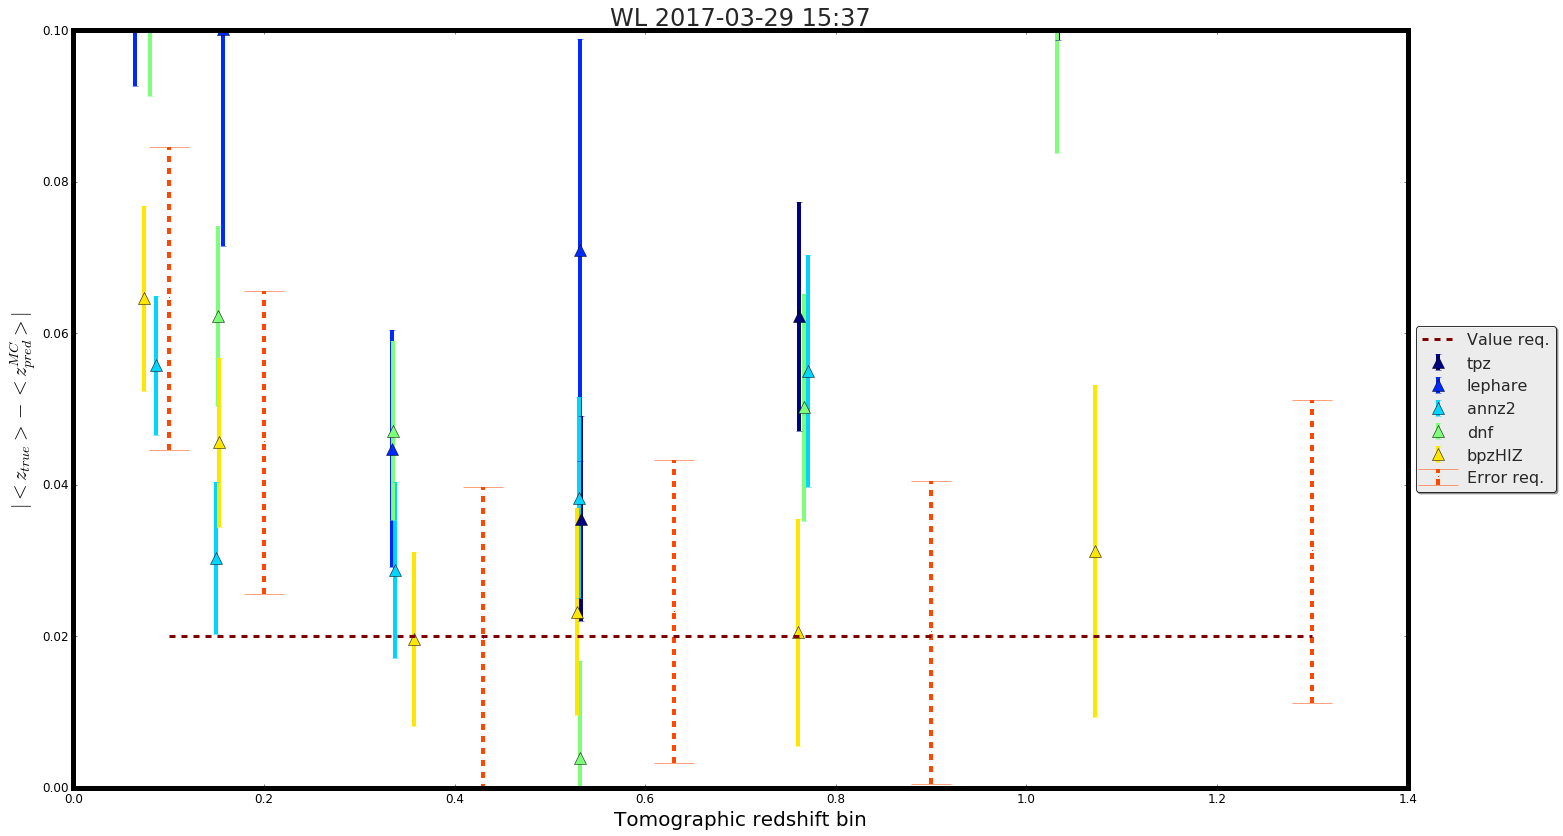

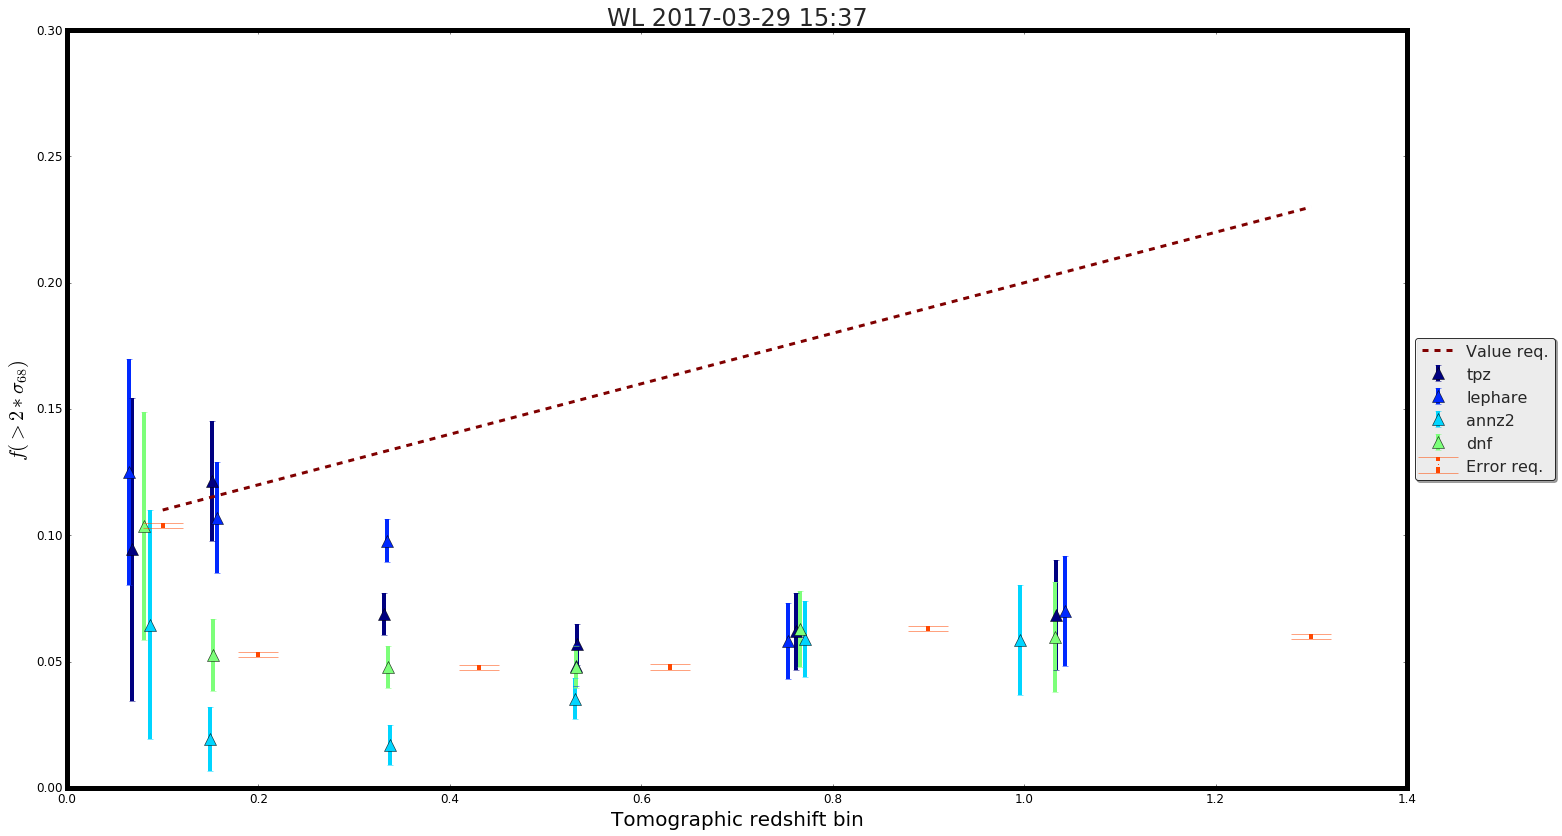

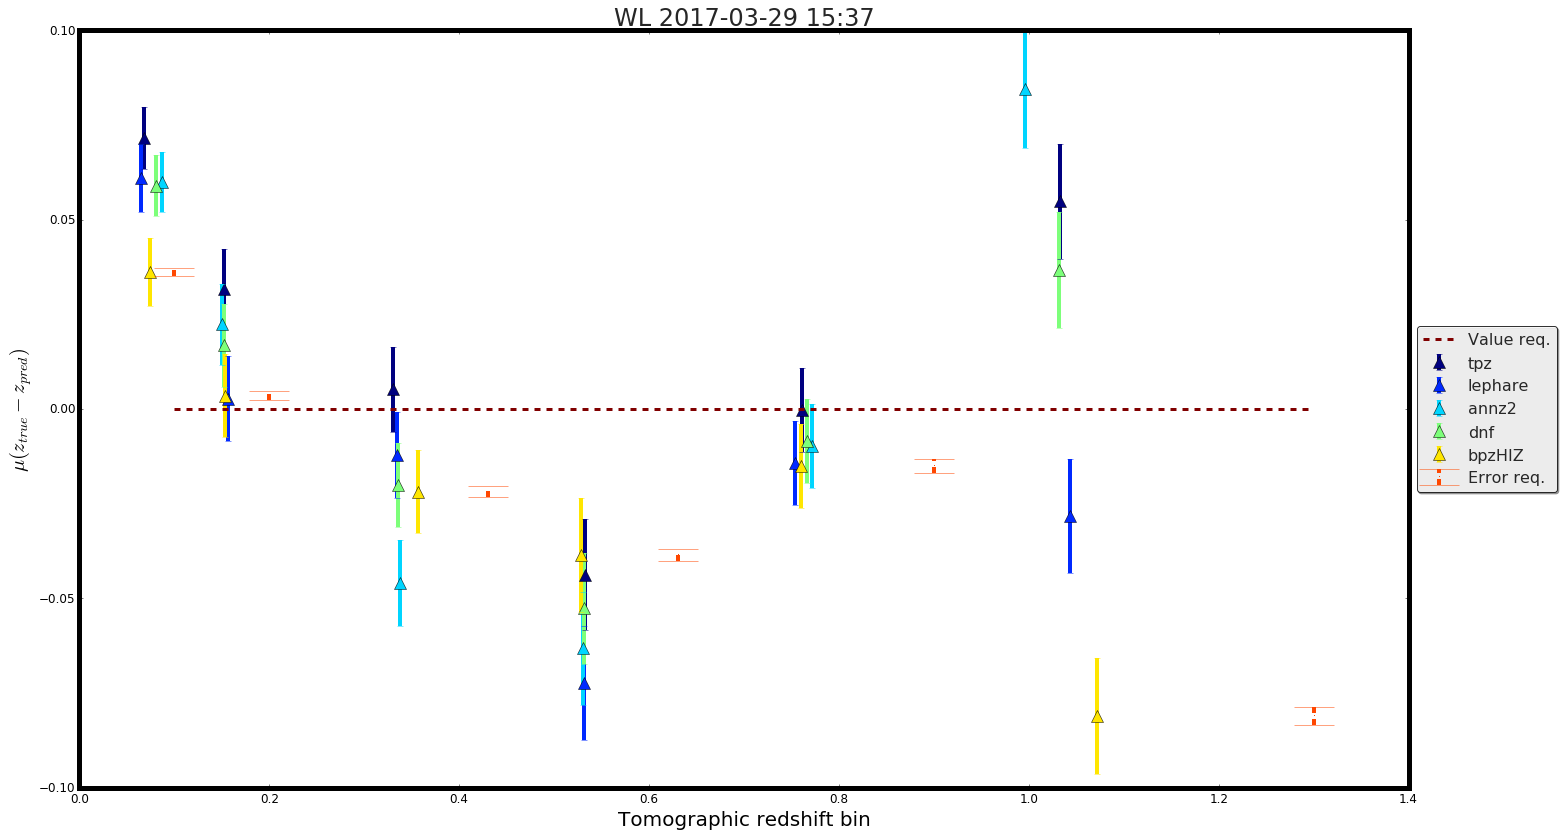

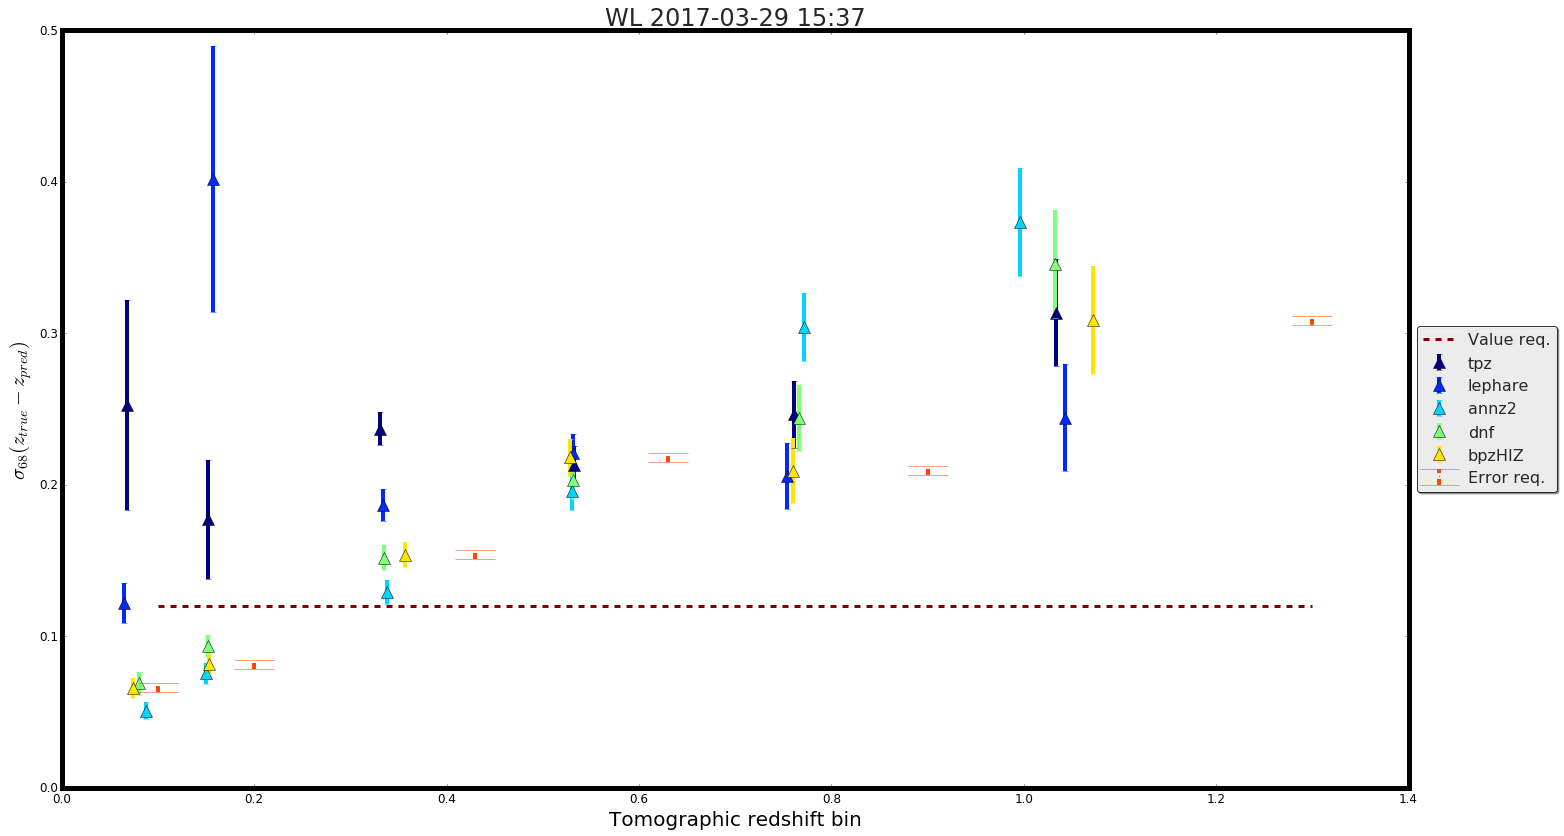

In [159]:
Ms = 12
lw = 4
show_z = True
print len(columns)+2

now = datetime.datetime.now()
#for each of the metrics
for m in requirements:
    
    f= plt.figure()
    ax = plt.subplot(111)
    color =iter(plt.cm.jet(np.linspace(0,1,len(columns)+2)))
#        color =iter(plt.cm.rainbow(np.linspace(0,1,len(columns)+2)))
    slit = 0.0

    
    for cc in columns:
        z = np.array(codes[cc]['z_tomo'])
        c=next(color)
        if len(np.array(codes[cc][m+'_tomo'])) > 0:
        
                  
            y = np.array(codes[cc][m+'_tomo'])
            ey = np.array(codes[cc][m+'_tomo_err'])
            ez = None
            
        
            #add offsets to x-axis plotting for viewability
            ax.errorbar(np.array(z)+slit, y, yerr=ey, fmt='^', markersize=str(Ms), elinewidth=lw, label=cc, color=c)
#        slit += 0.002
        #get requirements if they exist:
    

    c=next(color)
    err_req = requirements[m]['error'].scaling(np.array(bins))
    print err_req
    print len(bins)
    temp=ax.errorbar(np.array(bins), y, yerr=err_req, fmt=',',markersize=str(Ms), elinewidth=lw, label='Error req.', color=c, capsize=20)
    temp[-1][0].set_linestyle('--')
    c=next(color)
    val_req = requirements[m]['value'].scaling(np.array(bins))
    
    ax.plot(np.array(np.sort(bins)), val_req,'--', linewidth=3,label='Value req.', c=c)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), numpoints=1)
    
    plt.xlabel('Tomographic redshift bin')
    plt.title('%s %s' %(science_sample, str(now.strftime("%Y-%m-%d %H:%M"))))
    plt.ylim(plt_range[m])
    plt.ylabel(metric_latex[m])
    #plt.legend(loc=2) 
    plt.tight_layout()
    plt.savefig(science_sample + '.' + m + '.png')
    print (" ")

        